### Step 1. 데이터 구하기

- 주식데이터, 기상데이터 등을 이용해 직접 구해야합니다.

데이터는 https://finance.yahoo.com/quote/NQ=F?p=NQ=F 에서 2002년 1월 1일부터 2020년 11월 5일까지로 잡았습니다.

In [1]:
import os

csv_file = os.getenv('HOME')+'/aiffel/anomaly_detection/nasdaq/NQ=F.csv'

In [2]:
import pandas as pd

df = pd.read_csv(csv_file)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-01-02,1577.5,1618.5,1569.5,1617.5,1617.5,114019.0
1,2002-01-03,1618.0,1675.0,1613.0,1672.5,1672.5,149947.0
2,2002-01-04,1673.0,1704.5,1649.5,1679.0,1679.0,158205.0
3,2002-01-06,NaN,NaN,NaN,NaN,NaN,NaN
4,2002-01-07,1676.5,1702.0,1651.5,1661.5,1661.5,193253.0


### Step 2. 기본 통계분석으로 이상치 찾기

- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기

#### 한 단계 더 나아가기

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date           0
Open         992
High         992
Low          992
Close        992
Adj Close    992
Volume       992
dtype: int64

In [5]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 5776
삭제 후 데이터 길이(일자수): 4784


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

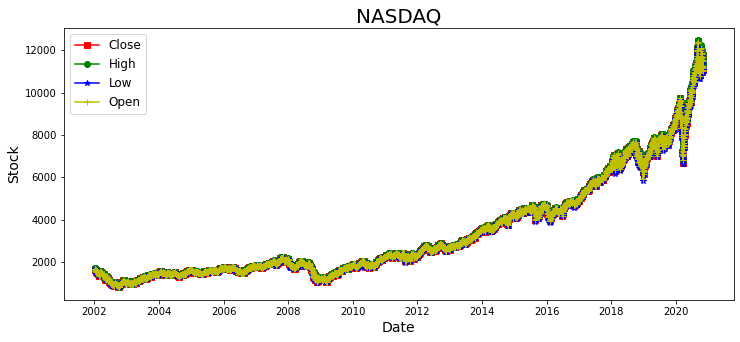

In [64]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

그래프만 보았을때 특별한 이상치는 보이지 않는 것 같습니다.  
z-test를 통해 정규분포 여부를 확인해보도록 하겠습니다.

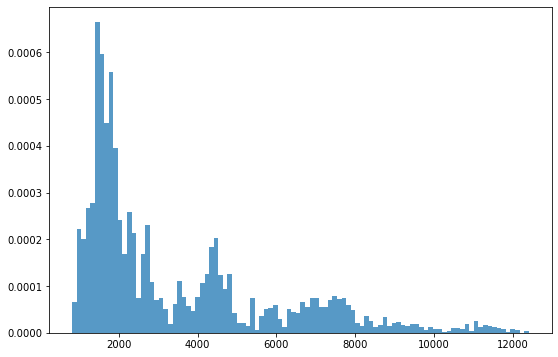

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(df.Close, 100, density=True, alpha=0.75)

In [8]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


### Time series decomposition 적용하기

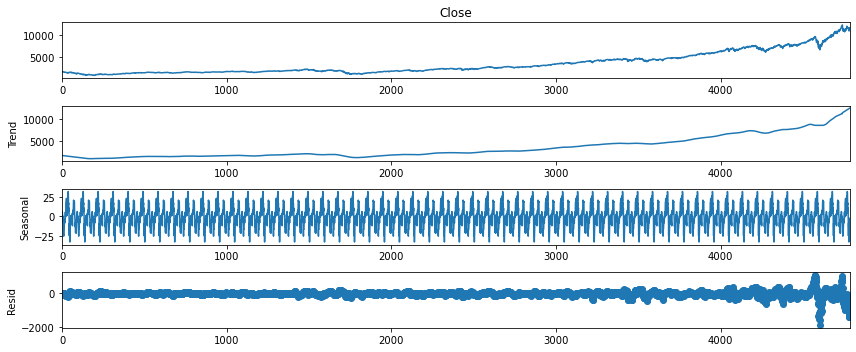

In [65]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=91, extrapolate_trend='freq') # 계절적 성분 91일로 가정
result.plot()
plt.show()

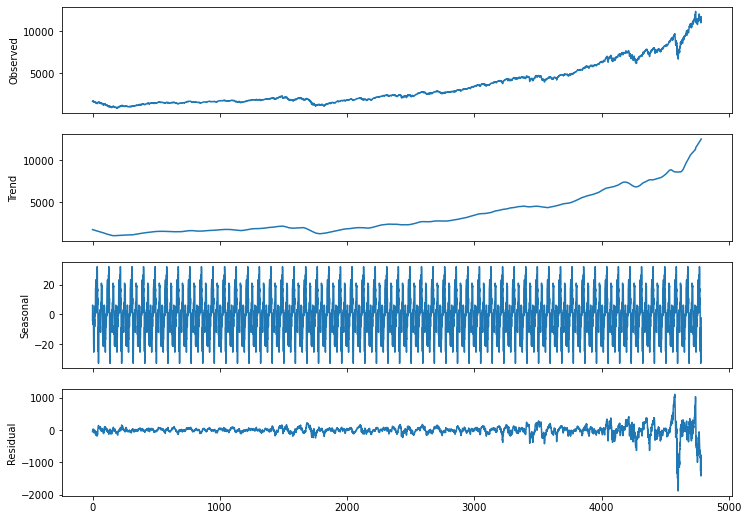

In [10]:
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

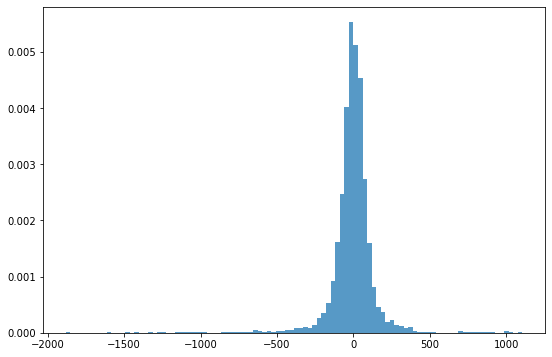

In [11]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [12]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-2.676580072568093 0.007437779075945683


이제 신뢰구간을 통해 이상치를 찾도록 하겠습니다

In [13]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))

평균: -6.058760514625123 표준편차: 156.56660400442152
이상치 갯수: 89


In [14]:
df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

4267   2018-12-20
4268   2018-12-21
4269   2018-12-26
4270   2018-12-27
4271   2018-12-28
          ...    
4779   2020-10-29
4780   2020-10-30
4781   2020-11-02
4782   2020-11-03
4783   2020-11-04
Name: Date, Length: 89, dtype: datetime64[ns]

In [15]:
marker_on = df.Date[result.resid[
    (result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

In [16]:
marker_on.shape

(89,)

In [45]:
for i in marker_on:
    print(i,"\n")

2018-12-20 00:00:00 

2018-12-21 00:00:00 

2018-12-26 00:00:00 

2018-12-27 00:00:00 

2018-12-28 00:00:00 

2019-01-03 00:00:00 

2019-05-31 00:00:00 

2019-06-03 00:00:00 

2020-01-30 00:00:00 

2020-02-04 00:00:00 

2020-02-05 00:00:00 

2020-02-06 00:00:00 

2020-02-07 00:00:00 

2020-02-09 00:00:00 

2020-02-10 00:00:00 

2020-02-11 00:00:00 

2020-02-12 00:00:00 

2020-02-13 00:00:00 

2020-02-14 00:00:00 

2020-02-16 00:00:00 

2020-02-18 00:00:00 

2020-02-19 00:00:00 

2020-02-20 00:00:00 

2020-02-21 00:00:00 

2020-02-23 00:00:00 

2020-02-24 00:00:00 

2020-03-09 00:00:00 

2020-03-11 00:00:00 

2020-03-12 00:00:00 

2020-03-13 00:00:00 

2020-03-15 00:00:00 

2020-03-16 00:00:00 

2020-03-17 00:00:00 

2020-03-18 00:00:00 

2020-03-19 00:00:00 

2020-03-20 00:00:00 

2020-03-22 00:00:00 

2020-03-23 00:00:00 

2020-03-24 00:00:00 

2020-03-25 00:00:00 

2020-03-26 00:00:00 

2020-03-27 00:00:00 

2020-03-29 00:00:00 

2020-03-30 00:00:00 

2020-03-31 00:00:00 

2020-04-01

주로 2020년의 데이터가 다 이상치로 잡히는 것같습니다.. 코로나의 영향인것 같습니다.

##### futher work
marker_on에 나온 점들 그래프에 표시해보기

##### code였던것
'''
fig = plt.figure(figsize=(12,15))
ax = fig.add_subplot(311)
ax.set_title('Close')
plt.plot(df.Date, df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(df.Date, df.Close, markevery = df.Date[df.Date[marker_on]])
'''

### Step 3. Unsupervised Clustering 으로 이상치 찾기

- k-means로 분석하기
- DBSCAN으로 분석하기

#### 한 단계 더 나아가기  

- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

In [17]:
# 데이터 전처리
def my_decompose(df, features, freq=50):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()
    
    # 사용할 feature 마다 decompose 를 수행합니다.
    for f in features:
        result = seasonal_decompose(df[f], 
                                    model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values
        
    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df, features=['Open','High','Low','Close','Volume'])
tdf.describe()

,Open,High,Low,Close,Volume
count,4784.000000,4784.000000,4784.000000,4784.000000,4784.000000
mean,3429.803111,3460.227749,3399.064290,3432.407869,300891.700573
std,2471.105542,2495.012782,2447.777938,2474.828986,103488.206243
min,914.415000,934.695000,895.770000,915.335000,155215.639894
25%,1583.597500,1596.202500,1571.261250,1583.530901,230754.670000
50%,2299.631250,2322.662500,2275.211250,2299.471699,275924.910000
75%,4496.659375,4526.544375,4462.890000,4498.585000,326983.575000
max,11950.056318,12123.699133,11770.995846,11952.493273,776809.340000


In [18]:
rdf.describe()

,Open,High,Low,Close,Volume
count,4784.000000,4784.000000,4784.000000,4784.000000,4784.000000
mean,-1.749426,-1.744445,-1.626800,-1.692094,140.777678
std,112.223880,101.575321,116.391044,109.600811,113730.291735
min,-1282.001706,-1493.358234,-1227.436276,-1389.214397,-603729.484407
25%,-36.417948,-33.808779,-36.867644,-36.065577,-56274.599322
50%,3.270161,2.894511,4.222326,3.266702,-1451.590766
75%,38.266296,35.883696,40.185532,39.381196,54944.268743
max,994.474300,934.232801,944.836456,993.799471,812099.819429


In [19]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
norm_rdf = scaler.transform(rdf)
norm_rdf

[ -1.74942603  -1.74444481  -1.62679964  -1.69209419 140.77767766]


array([[ 0.08674437,  0.25625104,  0.19224862,  0.42017298, -0.22762201],
       [ 0.47540299,  0.80540843,  0.58950161,  0.90614551,  0.15311741],
       [ 0.94664216,  1.10193452,  0.90998866,  1.04213964,  0.15207016],
       ...,
       [-7.87940098, -8.65294238, -6.89611223, -7.84812507, -0.1704645 ],
       [-7.65291464, -7.47109   , -5.90448298, -6.07523732, -1.03091858],
       [-6.04061471, -2.73476586, -4.58243514, -1.68969283, -1.17749188]])

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인합니다.

[1 1 1 ... 0 0 0]


In [21]:
# 라벨은 몇번 그룹인지 뜻합니다. 
# return_counts=True 를 해서 몇개의 샘플이 몇번 그룹에 할당되었는지 확인해요
lbl, cnt = np.unique(kmeans.labels_,return_counts=True) 
print(lbl)
print(cnt)

[0 1]
[ 751 4033]


In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:0-count:792',
 'group:1-count:13',
 'group:2-count:20',
 'group:3-count:81',
 'group:4-count:231',
 'group:5-count:66',
 'group:6-count:996',
 'group:7-count:322',
 'group:8-count:1005',
 'group:9-count:490',
 'group:10-count:22',
 'group:11-count:17',
 'group:12-count:79',
 'group:13-count:230',
 'group:14-count:420']

In [41]:
df[(kmeans.labels_==1)|(kmeans.labels_==10)|(kmeans.labels_==11)]

,Date,Open,High,Low,Close,Adj Close,Volume
4052,2018-02-09,6328.000000,6455.500000,6164.000000,6417.750000,6417.750000,787495.0
4269,2018-12-26,5902.000000,6310.000000,5820.500000,6285.500000,6285.500000,642440.0
4274,2019-01-03,6242.750000,6304.250000,6148.500000,6162.000000,6162.000000,714536.0
4377,2019-06-03,7110.000000,7132.500000,6941.250000,6993.750000,6993.750000,771723.0
4378,2019-06-04,7008.750000,7186.500000,6981.750000,7179.250000,7179.250000,565396.0
4570,2020-02-12,9536.250000,9628.250000,9523.750000,9625.750000,9625.750000,454472.0
4571,2020-02-13,9621.500000,9644.750000,9511.250000,9613.000000,9613.000000,613580.0
4572,2020-02-14,9626.250000,9659.250000,9588.000000,9632.250000,9632.250000,489387.0
4573,2020-02-16,9635.000000,9668.750000,9634.250000,9663.750000,9663.750000,297278.0
4574,2020-02-18,9635.000000,9687.500000,9534.250000,9636.000000,9636.000000,668505.0


In [24]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4784.000000,4784.000000,4784.000000,4784.000000,4784.000000,4.784000e+03
mean,3428.054150,3458.479695,3397.446739,3430.720544,3430.720544,3.010071e+05
std,2470.164812,2493.343675,2447.747322,2473.962523,2473.962523,1.574004e+05
min,810.000000,828.500000,797.500000,809.500000,809.500000,0.000000e+00
25%,1594.437500,1607.000000,1579.187500,1593.937500,1593.937500,2.072930e+05
50%,2297.000000,2317.750000,2276.625000,2296.500000,2296.500000,2.756235e+05
75%,4539.187500,4565.500000,4511.375000,4542.375000,4542.375000,3.646820e+05
max,12408.500000,12465.200195,12172.200195,12411.500000,12411.500000,1.580041e+06


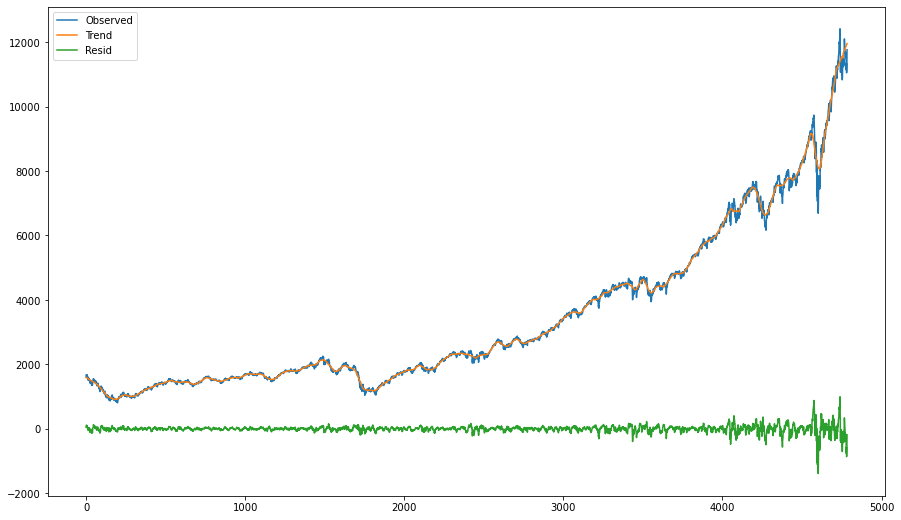

In [25]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
df.Close.plot(ax=ax, label='Observed', legend=True)
tdf.Close.plot(ax=ax, label='Trend', legend=True)
rdf.Close.plot(ax=ax,label='Resid', legend=True)
plt.show()

### DBSCAN 으로 이상치 찾기

In [26]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
clustering

DBSCAN(eps=0.7, min_samples=2)

In [27]:
print(clustering.labels_)

[ 0  0  0 ... -1 -1 -1]


In [28]:
lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

['group:-1-count:205',
 'group:0-count:4534',
 'group:1-count:2',
 'group:2-count:2',
 'group:3-count:5',
 'group:4-count:3',
 'group:5-count:3',
 'group:6-count:2',
 'group:7-count:3',
 'group:8-count:2',
 'group:9-count:2',
 'group:10-count:2',
 'group:11-count:2',
 'group:12-count:3',
 'group:13-count:3',
 'group:14-count:2',
 'group:15-count:2',
 'group:16-count:3',
 'group:17-count:2',
 'group:18-count:2']

DBSCAN에서는 18번그룹까지 자동으로 분류해주었습니다!

### Step 4. LSTM 오토인코더로 이상치 찾기

- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기

#### 한 단계 더 나아가기

- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
tf.random.set_seed(777)
np.random.seed(777)

### LSTM을 이용한 오토인코더 모델만들기

In [50]:
from sklearn.preprocessing import StandardScaler

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 128
features = ['Open','High','Low','Close','Volume']
n_features = len(features)
TRAIN_SIZE = int(len(df)*0.7)

# 데이터 전처리
# 표준정규분포화합니다.

scaler = StandardScaler()
scaler = scaler.fit(df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(df[features].values)

In [51]:
# keras TimeseriesGenerator 를 이용해서 간편하게 데이터 셋을 만듭니다

train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(128, 10, 5)
(128, 5)


In [52]:
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, 
         input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 64)            17920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                5184      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 10, 16)            2112      
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 46,277
Trainable params: 46,277
Non-trainable params: 0
__________________________________________________

In [53]:
# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장해둠
import os

checkpoint_path = os.getenv('HOME')+'/aiffel/anomaly_detection/kospi/mymodel.ckpt'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])

In [54]:
hist = model.fit(train_gen, 
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=100, 
          callbacks=[checkpoint, early_stop])

Epoch 1/100
37/38 [============================>.] - ETA: 0s - loss: 1.6654 - mae: 1.6654
Epoch 00001: val_loss improved from inf to 2.03396, saving model to /home/aiffel/aiffel/anomaly_detection/kospi/mymodel.ckpt
38/38 [==============================] - 1s 35ms/step - loss: 1.6517 - mae: 1.6517 - val_loss: 2.0340 - val_mae: 2.0340
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.0776 - mae: 1.0776
Epoch 00002: val_loss improved from 2.03396 to 0.97496, saving model to /home/aiffel/aiffel/anomaly_detection/kospi/mymodel.ckpt
38/38 [==============================] - 1s 26ms/step - loss: 1.0776 - mae: 1.0776 - val_loss: 0.9750 - val_mae: 0.9750
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.6581 - mae: 0.6581
Epoch 00003: val_loss improved from 0.97496 to 0.73428, saving model to /home/aiffel/aiffel/anomaly_detection/kospi/mymodel.ckpt
38/38 [==============================] - 1s 28ms/step - loss: 0.6581 - mae: 0.6581 - val_loss: 0.7343 - val

In [55]:
model.load_weights(checkpoint_path)

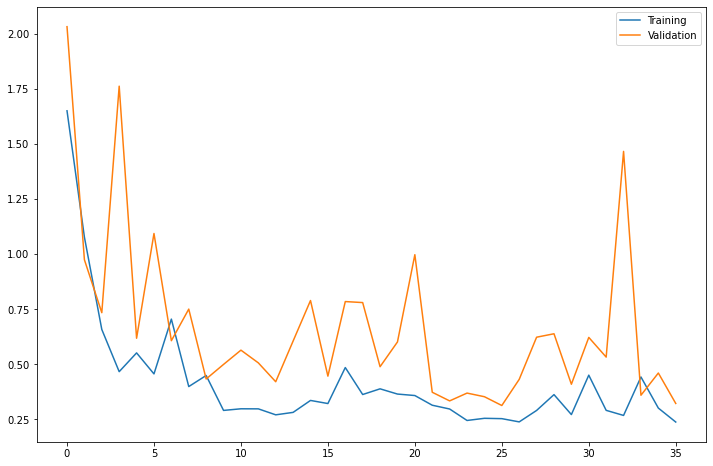

In [56]:
fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

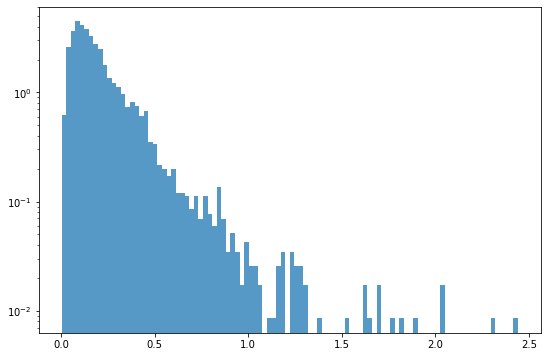

In [57]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받습니다
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그립니다
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [62]:
import copy

test_df = copy.deepcopy(df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 1
test_df.loc[test_df.Loss>threshold]

,Date,Open,High,Low,Close,Adj Close,Volume,Loss
1425,2007-08-16,1877.500000,1878.750000,1813.750000,1856.500000,1856.500000,982573.0,1.060301
3212,2014-10-15,3823.750000,3831.500000,3691.250000,3752.000000,3752.000000,831107.0,1.190585
3425,2015-08-24,4183.750000,4196.250000,3908.250000,4003.250000,4003.250000,746533.0,1.284504
3426,2015-08-25,3998.000000,4204.250000,3997.750000,4028.500000,4028.500000,630057.0,1.023132
4038,2018-02-05,6752.250000,6813.500000,6387.750000,6429.250000,6429.250000,931677.0,1.287608
4039,2018-02-06,6473.000000,6677.500000,6260.250000,6653.750000,6653.750000,813419.0,1.071062
4042,2018-02-09,6328.000000,6455.500000,6164.000000,6417.750000,6417.750000,787495.0,1.005335
4074,2018-03-28,6550.250000,6582.250000,6421.000000,6477.250000,6477.250000,948120.0,1.234173
4209,2018-10-10,7394.750000,7412.000000,7000.000000,7032.000000,7032.000000,924204.0,1.243725
4210,2018-10-11,7010.250000,7138.000000,6907.750000,7031.000000,7031.000000,1146270.0,1.708726


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/lines.py:191: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return Path(verts[markevery], _slice_or_none(codes, markevery))


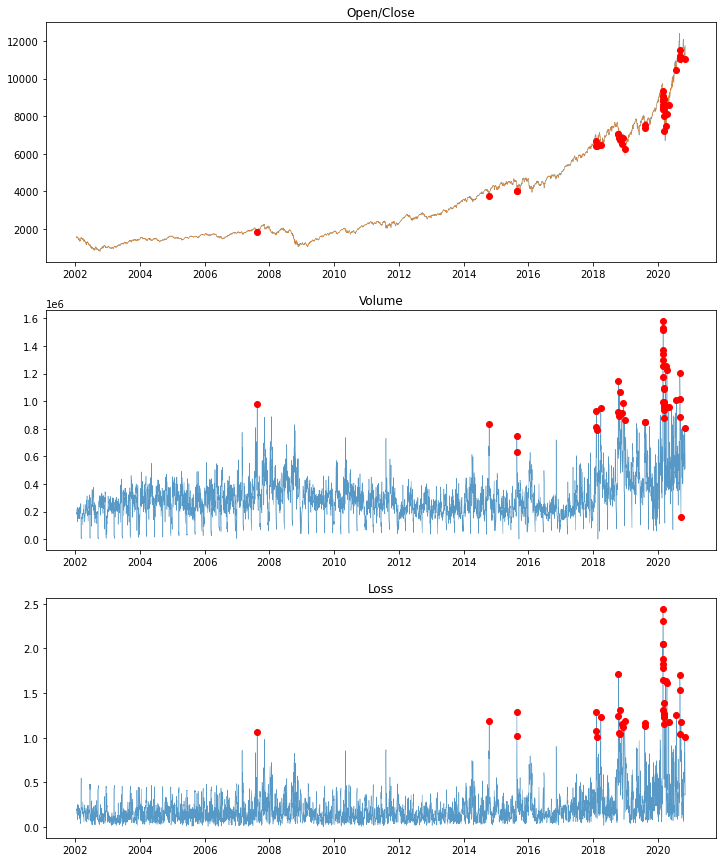

In [63]:
fig = plt.figure(figsize=(12,15))


# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('Open/Close')
plt.plot(test_df.Date, test_df.Close, linewidth=0.5, alpha=0.75, label='Close')
plt.plot(test_df.Date, test_df.Open, linewidth=0.5, alpha=0.75, label='Open')
plt.plot(test_df.Date, test_df.Close, 'or', markevery=[mae_loss>threshold])

# 거래량 그래프입니다
ax = fig.add_subplot(312)
ax.set_title('Volume')
plt.plot(test_df.Date, test_df.Volume, linewidth=0.5, alpha=0.75, label='Volume')
plt.plot(test_df.Date, test_df.Volume, 'or', markevery=[mae_loss>threshold])

# 오차율 그래프입니다
ax = fig.add_subplot(313)
ax.set_title('Loss')
plt.plot(test_df.Date, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.Date, test_df.Loss, 'or', markevery=[mae_loss>threshold])

# 결과 및 분석

시계열 Residual분석, k-mean,DBSCAN분석, LSTM 오토인코더 학습을 통하여 코스피 지수를 분석해보는 시간을 가졌습니다.

대부분의 이상치는 2020년도에 있던 이상치로 밝혀졌습니다.. 2020년도 이전에 발생한 몇몇의 이상치는 제거한뒤 다른값으로 변경해주고 2020년의 데이터는 장기적으로 어떻게 처리해야 할지 고민을 해봐야 할 것같습니다.